In [1]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [23]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2022)

In [24]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images,val_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tf.Tensor([8], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([8], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([5], shape=(1,), dtype=uint8)
tf.Tensor([0], shape=(1,), dtype=uint8)
tf.Tensor([5], shape=(1,), dtype=uint8)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([8], shape=(1,), dtype=uint8)
tf.Tensor([4], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([6], shape=(1,), dtype=uint8)


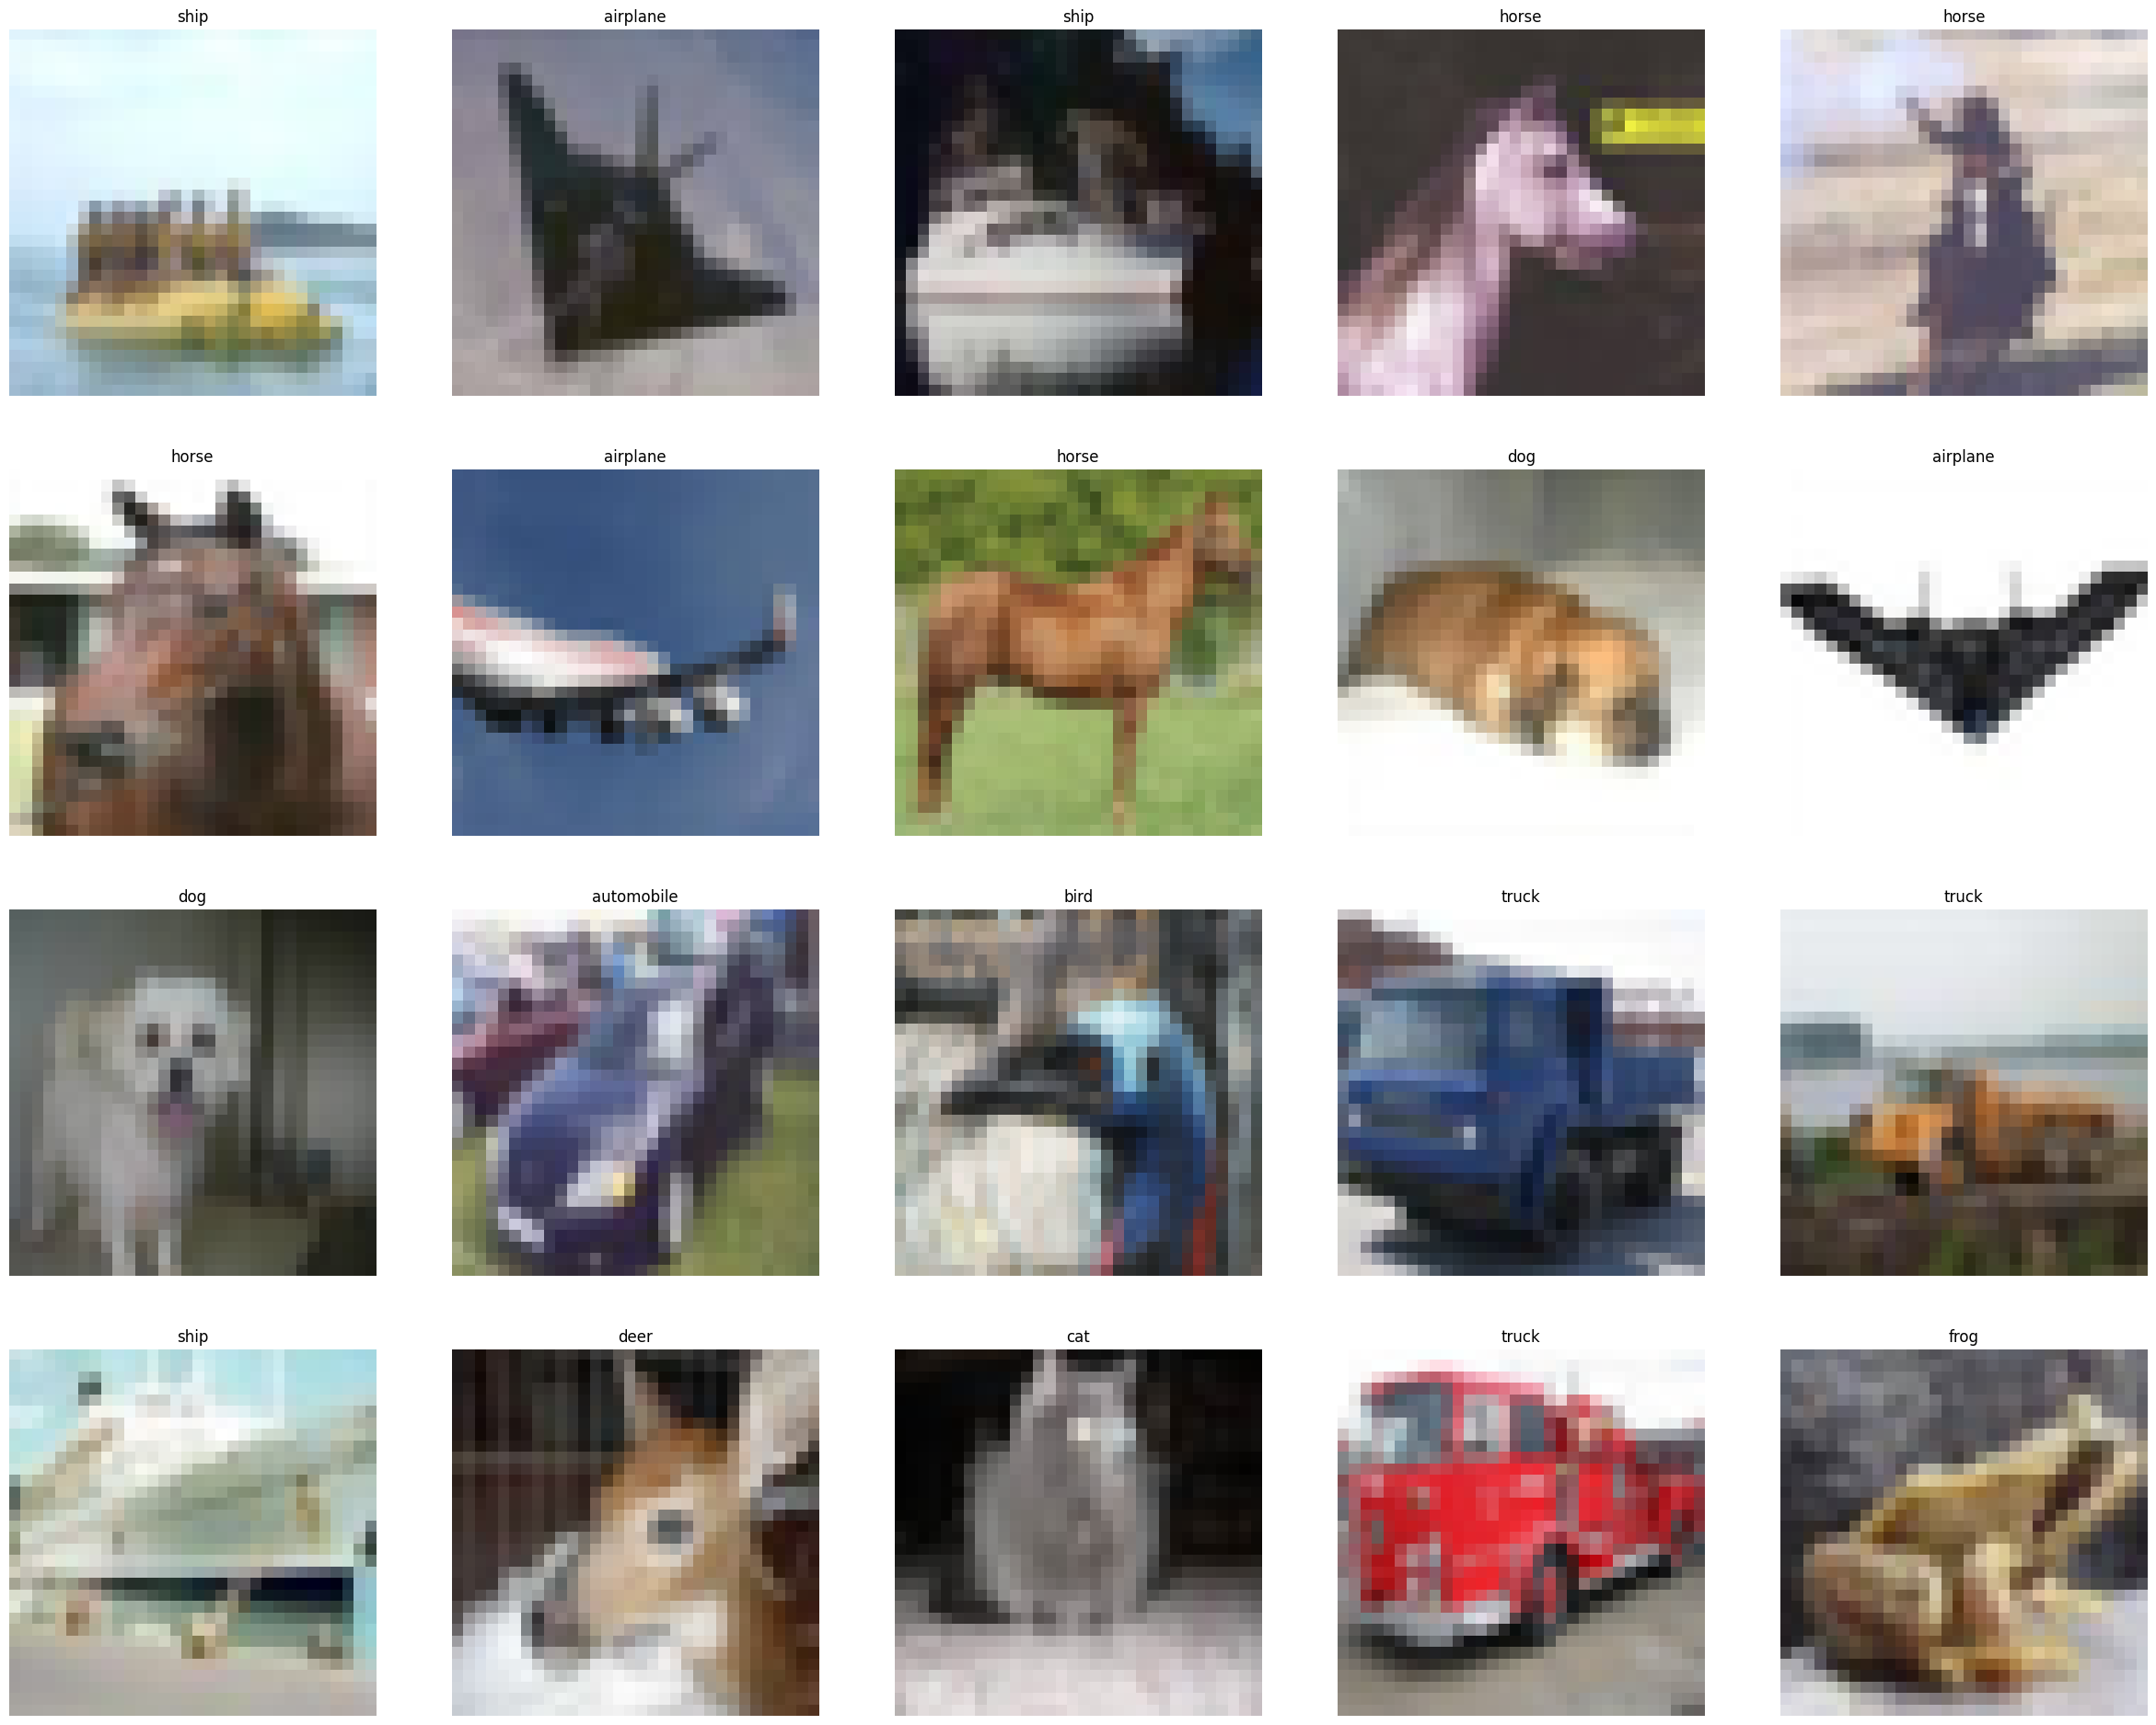

In [25]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [26]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print('Train set size:',train_ds_size)
print('Validation set size:',val_ds_size)
print('Test set size:',test_ds_size)

Train set size: 40000
Validation set size: 10000
Test set size: 10000


In [27]:
def process_image(image, label):
  image = tf.image.per_image_standardization(image)
  return image, label

train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
val_ds=(val_ds
          .map(process_image)
          .shuffle(buffer_size=val_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
          )


In [28]:
def VGG_block(num_convs, num_channels):
    block = Sequential()
    for _ in range(num_convs):
        block.add(Conv2D(filters=num_channels, kernel_size=3, padding='same', activation='relu'))
    block.add(MaxPooling2D(pool_size=2, strides=2))
    return block

def VGG_net(arch, lr=0.1, num_classes=10):
    model = Sequential()
    for (num_convs, num_channels) in arch:
        model.add(VGG_block(num_convs, num_channels))
    model.add(
        Sequential([
            Flatten(),
            Dense(4096,activation='relu'),
            Dropout(0.5),
            Dense(4096,activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
    )
    return model

In [29]:
model = VGG_net(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(), metrics=['accuracy'])
model.build((1,32,32,3))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (1, 16, 16, 16)           448       
_________________________________________________________________
sequential_16 (Sequential)   (1, 8, 8, 32)             4640      
_________________________________________________________________
sequential_17 (Sequential)   (1, 4, 4, 64)             55424     
_________________________________________________________________
sequential_18 (Sequential)   (1, 2, 2, 128)            221440    
_________________________________________________________________
sequential_19 (Sequential)   (1, 1, 1, 128)            295168    
_________________________________________________________________
sequential_20 (Sequential)   (1, 10)                   17350666  
Total params: 17,927,786
Trainable params: 17,927,786
Non-trainable params: 0
_________________________________________

In [30]:
history=model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    validation_freq=1
)

Epoch 1/10
1250/1250 [==============================] - 35s 25ms/step - loss: 2.2983 - accuracy: 0.1226 - val_loss: 2.2707 - val_accuracy: 0.1559
Epoch 2/10
1250/1250 [==============================] - 32s 25ms/step - loss: 2.0498 - accuracy: 0.2069 - val_loss: 1.8522 - val_accuracy: 0.2713
Epoch 3/10
1250/1250 [==============================] - 27s 21ms/step - loss: 1.8193 - accuracy: 0.3024 - val_loss: 1.6938 - val_accuracy: 0.3561
Epoch 4/10
1250/1250 [==============================] - 22s 17ms/step - loss: 1.6525 - accuracy: 0.3735 - val_loss: 1.5432 - val_accuracy: 0.4182
Epoch 5/10
1250/1250 [==============================] - 23s 17ms/step - loss: 1.4931 - accuracy: 0.4412 - val_loss: 1.4136 - val_accuracy: 0.4741
Epoch 6/10
1250/1250 [==============================] - 22s 17ms/step - loss: 1.3593 - accuracy: 0.4997 - val_loss: 1.3604 - val_accuracy: 0.4981
Epoch 7/10
1250/1250 [==============================] - 22s 17ms/step - loss: 1.2427 - accuracy: 0.5494 - val_loss: 1.1634 -

In [31]:
cross_entropy = model.evaluate(test_ds)
print("Test loss and accuracy: ",cross_entropy)

312/312 [==============================] - 2s 6ms/step - loss: 0.9806 - accuracy: 0.6598
Test loss and accuracy:  [0.98057621717453, 0.6597555875778198]


In [33]:
test_preds=model.predict(test_images)
print("First 10 test results:")
for i in range(10):
    index_max = max(range(len(test_preds[i])), key=test_preds[i].__getitem__)
    print("Prediction: {} Actual: {}".format(index_max,test_labels[i]))

First 10 test results:
Prediction: 6 Actual: [3]
Prediction: 8 Actual: [8]
Prediction: 1 Actual: [8]
Prediction: 8 Actual: [0]
Prediction: 6 Actual: [6]
Prediction: 6 Actual: [6]
Prediction: 2 Actual: [1]
Prediction: 6 Actual: [6]
Prediction: 6 Actual: [3]
Prediction: 1 Actual: [1]
